<a href="https://colab.research.google.com/github/rboghe/cened/blob/master/cened_1_2_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [308]:
import os
import urllib.request
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from lightgbm import LGBMRegressor
import seaborn as sns

# Silence panda's setting with copy warning
pd.options.mode.chained_assignment = None

# Set Seaborn style
sns.set_theme(style="white")

# Load data

In [309]:
# Cened 1.2
url = 'https://www.dati.lombardia.it/api/views/rsg3-xhvk/rows.csv?accessType=DOWNLOAD'


if os.path.isfile('/tmp/cened12.csv'):
  pass
else:
  urllib.request.urlretrieve(url, '/tmp/cened12.csv')

In [310]:
# DDH
url = 'https://raw.githubusercontent.com/rboghe/cened/master/degreedays.txt'

urllib.request.urlretrieve(url, '/tmp/ddh.csv')

ddh = pd.read_csv('/tmp/ddh.csv', usecols = ['comune','dd'])

In [311]:
cols = ['COMUNE','FOGLIO', 'PARTICELLA','SUPERFICIE_DISPERDENTE',
          'TRASMITTANZA_MEDIA_COPERTURA','TRASMITTANZA_MEDIA_INVOLUCRO',
          'TRASMITTANZA_MEDIA_BASAMENTO','TRASMITTANZA_MEDIA_SERRAMENTO',
          'SUPERFICIE_LORDA', 'VOLUME_LORDO', 'DESTINAZIONE_DI_USO',
          'ANNO_COSTRUZIONE','SUPERFICIE_VETRATA_OPACA', 'VOLUME_NETTO',
          'SUPERFICIE_NETTA', 'NUMERO_RICAMBI_ORARI', 'EPH']
  
cened_old = pd.read_csv('/tmp/cened12.csv', usecols = cols)

# Preprocessing

In [312]:
# Drop buildings with NaN values
cened_old.dropna(inplace = True)

# We'll use residential buildings only
cened_old = cened_old[cened_old['DESTINAZIONE_DI_USO'] == 'E.1(1)']

# Add ddh
cened_old['COMUNE'] = cened_old['COMUNE'].str.lower()
ddh['comune'] = ddh['comune'].str.lower()
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"o`",  "o'")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"baranzate",  "bollate")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"bovisio masciago",  "bovisio-masciago")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"cornate d`adda",  "cornate d'adda")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"cortenuova",  "cortenova")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"sant'omobono terme",  "sant'omobono imagna")
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"é",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"ò",  "o'")
ddh['comune'] = ddh['comune'].str.replace(r"ù",  "u'")

cened_old = cened_old.merge(ddh, left_on='COMUNE', right_on='comune', how='left')



# Correct floats
for col in ['SUPERFICIE_LORDA', 'SUPERFICIE_NETTA', 'VOLUME_LORDO', 'VOLUME_NETTO',
       'SUPERFICIE_DISPERDENTE', 'SUPERFICIE_VETRATA_OPACA',
       'TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA',
       'TRASMITTANZA_MEDIA_BASAMENTO', 'TRASMITTANZA_MEDIA_SERRAMENTO', 'EPH', 'dd']:
    cened_old[col] = cened_old[col].astype(str)
    cened_old[col] = cened_old[col].str.replace(r',', '')
    cened_old[col] = cened_old[col].astype("float")

In [313]:
# Full DB of residential buildings without missing data
print(len(cened_old))

306008


# Feature engineering

In [314]:
# Opaque surface
cened_old['SUP_OPACA'] = cened_old['SUPERFICIE_DISPERDENTE']/(1+cened_old['SUPERFICIE_VETRATA_OPACA'])

# Opaque surface
cened_old['SUP_FINESTRATA'] = cened_old['SUPERFICIE_DISPERDENTE'] - cened_old['SUP_OPACA']

# Take care of construction year
cened_old.ANNO_COSTRUZIONE = cened_old.ANNO_COSTRUZIONE.astype(str)
cened_old.ANNO_COSTRUZIONE = cened_old.ANNO_COSTRUZIONE.map(lambda x:x[-4:])
cened_old.ANNO_COSTRUZIONE = cened_old.ANNO_COSTRUZIONE.astype(int)

cened_old['PERIODO'] = pd.cut(cened_old.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000],
     labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', '1993-2006','After 2006']).cat.codes

# Take care of ach
cened_old.NUMERO_RICAMBI_ORARI = cened_old.NUMERO_RICAMBI_ORARI.astype(str)
cened_old.NUMERO_RICAMBI_ORARI = cened_old.NUMERO_RICAMBI_ORARI.map(lambda x:x[:6])
cened_old.NUMERO_RICAMBI_ORARI = cened_old.NUMERO_RICAMBI_ORARI.astype(float)

# Filtering

Taken from previous studies!

In [315]:
# Drop buildings with wrong thermal conductivity
for col in ['TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA',
       'TRASMITTANZA_MEDIA_BASAMENTO']:
    cened_old = cened_old[cened_old[col] > 0]
    cened_old = cened_old[cened_old[col] < 4]

cened_old = cened_old[cened_old['TRASMITTANZA_MEDIA_SERRAMENTO'] > 0]
cened_old = cened_old[cened_old['TRASMITTANZA_MEDIA_SERRAMENTO'] < 6]

# Drop buildings with wrong EPH
cened_old = cened_old[cened_old['EPH'] > 5]
cened_old = cened_old[cened_old['EPH'] < 1000]

# Drop buildings with wrong An
cened_old = cened_old[cened_old['SUPERFICIE_NETTA'] > 50]

# Drop buildings with wrong Vn
cened_old = cened_old[cened_old['VOLUME_NETTO'] > 150]

# Drop buildings with wrong average height
cened_old['ALTEZZA_MEDIA'] = cened_old['VOLUME_NETTO']/cened_old['SUPERFICIE_NETTA']
cened_old = cened_old[cened_old['ALTEZZA_MEDIA'] > 2.4]


# Drop buildings with wrong mean thermal conductivity
cened_old['TRASMITTANZA_MEDIA'] = (cened_old['TRASMITTANZA_MEDIA_SERRAMENTO'] + cened_old['TRASMITTANZA_MEDIA_COPERTURA'] +
         cened_old['TRASMITTANZA_MEDIA_BASAMENTO'] + cened_old['TRASMITTANZA_MEDIA_INVOLUCRO'])/4

cened_old = cened_old[cened_old['TRASMITTANZA_MEDIA'] > 0.15]
cened_old = cened_old[cened_old['TRASMITTANZA_MEDIA'] < 4]

# Glazed surface
cened_old = cened_old[cened_old['SUP_FINESTRATA'] > 1]

# Glazing ratio
cened_old = cened_old[cened_old['SUPERFICIE_VETRATA_OPACA'] > 0]
cened_old = cened_old[cened_old['SUPERFICIE_VETRATA_OPACA'] < 0.9]

In [316]:
print(len(cened_old))

263234


# Data analysis

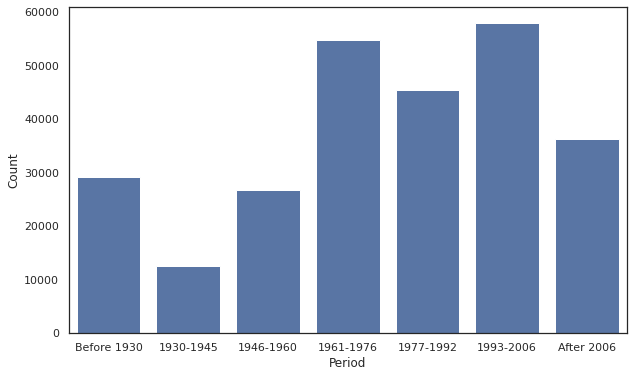

In [317]:
# Period
fig = plt.figure(figsize = (10,6))
cplot = sns.countplot(x = pd.cut(cened_old.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'Period')
plt.show()

# Shuffle

In [318]:
cened = cened_old.sample(frac=1).reset_index(drop=True)

# Reserve a test set

In [319]:
msk = np.random.rand(len(cened)) < 0.8
train = cened[msk]
test = cened[~msk]

In [320]:
print(len(train))

210926


In [321]:
print(len(test))

52308


# Define MAPE

In [322]:
def neg_mape(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  return -np.abs((y_true - y_pred)/y_true).mean()

In [323]:
def modified_neg_mape(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  errors = np.abs((y_true - y_pred)/y_true)
  index = np.argwhere(errors > 1)
  mod_errors = np.delete(errors, index)
  return -mod_errors.mean()

In [324]:
neg_mape_scorer = make_scorer(neg_mape, greater_is_better=True)

In [325]:
modified_neg_mape_scorer = make_scorer(modified_neg_mape, greater_is_better=True)

# Random search

In [326]:
mlcol = ['PERIODO','SUPERFICIE_LORDA', 'SUPERFICIE_NETTA', 'VOLUME_LORDO', 
         'VOLUME_NETTO', 'SUPERFICIE_DISPERDENTE',
         'TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA',
         'TRASMITTANZA_MEDIA_BASAMENTO', 'TRASMITTANZA_MEDIA_SERRAMENTO',
         'dd','SUP_FINESTRATA','SUP_OPACA', 'SUPERFICIE_VETRATA_OPACA',
         'NUMERO_RICAMBI_ORARI']

In [327]:
cat_feats = ['PERIODO']

In [328]:
param_dist = {'feature_fraction': np.linspace(0.4, 1, num=7),
              'num_leaf' : list(range(20,40)),
             'max_depth' : [-1],
             'max_bin' : [100, 200, 300, 500, 750, 1000, 2000],
             'bagging_fraction' : np.linspace(0.4, 1, num=14),
             'bagging_freq' : list(range(1,10)),
             'lambda_l1' : stats.uniform(0, 0.6),
             'lambda_l2' : stats.uniform(0, 0.6)}

lgbm = LGBMRegressor(n_estimators = 200, silent = True, verbose = 0, is_training_metric = True, n_jobs = 1, 
                     eval_metric  = 'mape')

n_iter_search = 100

random_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=n_iter_search, 
                                   scoring={'MAPE' : modified_neg_mape_scorer, 'R2' : 'r2'} , cv = 5, n_jobs = 6, verbose = 2, refit = 'MAPE')

random_search.fit(cened[mlcol], cened['EPH'], categorical_feature = cat_feats)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed: 32.4min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed: 46.8min finished
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PERIODO']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           eval_metric='mape',
                                           importance_type='split',
                                           is_training_metric=True,
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=200,
                                           n_jobs=1, num_leaves=31,
                                           objective=None, random_sta...
                                        'lambda_l2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8baa8c3ba8>,
            

# Print results

In [329]:
print(random_search.best_params_)

{'bagging_fraction': 0.9538461538461538, 'bagging_freq': 5, 'feature_fraction': 1.0, 'lambda_l1': 0.0032008623603136054, 'lambda_l2': 0.2930464255470075, 'max_bin': 1000, 'max_depth': -1, 'num_leaf': 29}


In [330]:
print(random_search.best_score_)

-0.16720073563051802


In [331]:
# Create a results df
cv_df = pd.DataFrame(random_search.cv_results_)
cv_df = cv_df.sort_values(by = ['rank_test_MAPE']).reset_index()

# Filter columns
res_cols = [col for col in cv_df if col.startswith('split')]

# Select best iter
best_res = cv_df.loc[0]

# Print results for each fold
print(best_res[res_cols])

split0_test_MAPE    -0.16864
split1_test_MAPE   -0.166589
split2_test_MAPE   -0.166645
split3_test_MAPE   -0.166864
split4_test_MAPE   -0.167266
split0_test_R2      0.872572
split1_test_R2       0.87619
split2_test_R2      0.874375
split3_test_R2      0.876998
split4_test_R2      0.874472
Name: 0, dtype: object


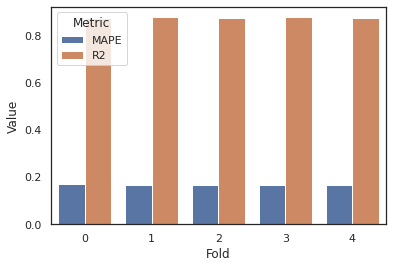

In [333]:
df = pd.DataFrame(best_res[res_cols])
df = df.rename(columns = {0:'Value'})
df['Fold'] = df.index.str[5:6]
df['Metric'] = df.index.str[12:]
df['Value'] = np.where(df['Metric'] == 'MAPE', df['Value'] * -1, df['Value'])
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df)

# Train the final model

In [334]:
light = LGBMRegressor(n_estimators = 10000, silent = False, verbose = 2, is_training_metric = True, n_jobs = 6)
light.set_params(**random_search.best_params_)

LGBMRegressor(bagging_fraction=0.9538461538461538, bagging_freq=5,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=1.0, importance_type='split',
              is_training_metric=True, lambda_l1=0.0032008623603136054,
              lambda_l2=0.2930464255470075, learning_rate=0.1, max_bin=1000,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=10000, n_jobs=6, num_leaf=29,
              num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=2)

In [335]:
light.fit(train[mlcol], train['EPH'], categorical_feature = cat_feats)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PERIODO']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(bagging_fraction=0.9538461538461538, bagging_freq=5,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=1.0, importance_type='split',
              is_training_metric=True, lambda_l1=0.0032008623603136054,
              lambda_l2=0.2930464255470075, learning_rate=0.1, max_bin=1000,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=10000, n_jobs=6, num_leaf=29,
              num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=2)

# Test the model

In [336]:
y_pred = light.predict(test[mlcol]).clip(0)

In [337]:
results_df = pd.DataFrame({'predicted' : y_pred, 'true' : test['EPH']})
results_df['error'] = np.abs((results_df['true'] - results_df['predicted'])/results_df['true'])*100

In [338]:
# MAPE
results_df['error'].mean()

18.443997295842415

In [339]:
# Max % error
results_df['error'].max()

5984.253397376704

In [340]:
# Row with the highest % error
results_df.iloc[results_df['error'].argmax()]

predicted     486.679429
true            7.999000
error        5984.253397
Name: 254056, dtype: float64

In [341]:
# MAPE without >100%
results_df[results_df.error <= 100].error.mean()

15.66921293544868

In [342]:
# R2 
print(r2_score(test['EPH'], y_pred))

0.8869746280731347


In [343]:
# R2 without >100%
print(r2_score(results_df[results_df.error <= 100].true, results_df[results_df.error <= 100].predicted))

0.8961127029254408


In [344]:
results_df

,predicted,true,error
12,319.361112,337.1064,5.264002
14,89.790204,85.7843,4.669740
17,219.545509,247.7039,11.367763
26,187.121059,190.5135,1.780683
36,158.398030,198.5449,20.220550
...,...,...,...
263213,124.546394,141.8701,12.210964
263217,188.032921,164.0724,14.603627
263224,302.153972,337.5744,10.492629
263227,375.192589,328.4093,14.245422


# Error analysis

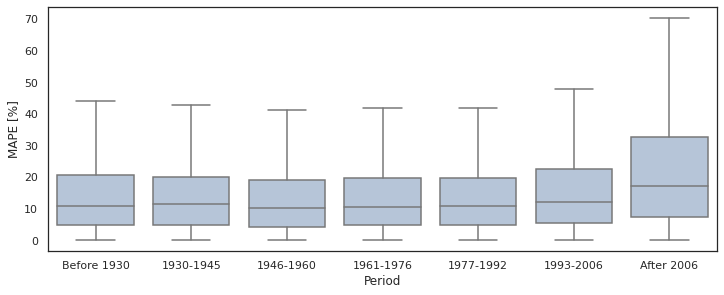

In [345]:
# Period
bins = pd.cut(test.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006'])

fig = plt.figure(figsize = (12, 4.5))
box = sns.boxplot(y = results_df.error, x = bins, 
                  color='lightsteelblue', orient = 'v', 
                  showfliers = False)

box.set(ylabel = 'MAPE [%]', xlabel = 'Period')
plt.show()

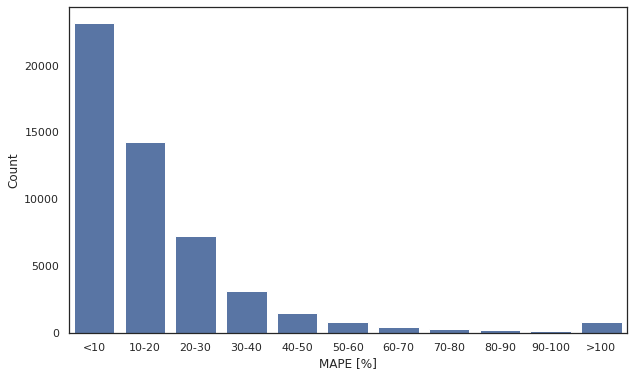

In [346]:
# Error
fig = plt.figure(figsize = (10,6))
cplot = sns.countplot(x = pd.cut(results_df.error, bins=[0,10,20,30,40,50,60,70,80,90,100,10000],
                                 labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '>100']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'MAPE [%]')
plt.show()

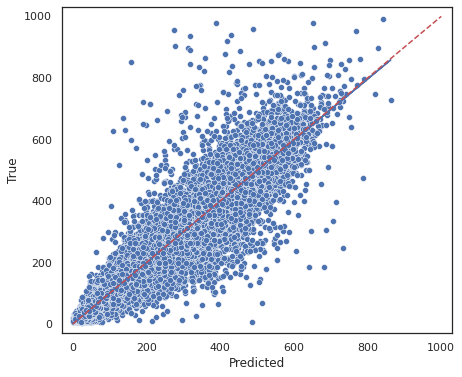

In [348]:
# Scatterplot
fig = plt.figure(figsize = (7,6))
scatter = sns.scatterplot(data=results_df, x="predicted", y="true")
scatter.set(ylabel = 'True', xlabel = 'Predicted',
            xlim=(-30, 1030), ylim=(-30, 1030))
m, b = np.polyfit(results_df['predicted'], results_df['true'], 1)
plt.plot(results_df['predicted'].values, m*results_df['predicted'] + b)
plt.plot([0, 1000], [0,1000], c = 'r', linestyle='--')
plt.show()